This requires the IEX_TOKEN environment variable to be set to the IEX API token.

In [1]:
from iexfinance.stocks import Stock, get_historical_data
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys

In [2]:
sectors_of_interest = ["Communication Services", "Information Technology", 
                       "Consumer Staples", "Consumer Discretionary", "Financials"]

In [3]:
df_spx = pd.read_csv('sp500_constituents.csv',encoding = "ISO-8859-1",quotechar='"')

In [4]:
df_pricechanges = pd.DataFrame(index=df_spx["Symbol"], 
                               columns=["Symbol", "Security", "GICS_Sector", "GICS_Sub_Industry", 
                                        "latestPrice", "lastweekPrice", "week52High", 
                                        "pct_change1D", "pct_change1W", "pct_changeFrom1YHigh"])


In [5]:
def retrieve_new_data():
    lastweek_date = datetime.today() - timedelta(days=7) - timedelta(days=max(datetime.today().weekday() - 4, 0))
    
    print("Today:",datetime.today(),", Last week:",lastweek_date)

    for i in range(len(df_spx)):
        print("Retrieving " + df_spx["Symbol"][i] + "    ", end="\r", flush=True)
        df_pricechanges["Symbol"][i] = df_spx["Symbol"][i]
        df_pricechanges["Security"][i] = df_spx["Security"][i]
        df_pricechanges["GICS_Sector"][i] = df_spx["GICS_Sector"][i]
        df_pricechanges["GICS_Sub_Industry"][i] = df_spx["GICS_Sub_Industry"][i]

        quote = Stock(df_spx["Symbol"][i], output_format="json").get_quote()
        df_pricechanges["latestPrice"][i] = quote["latestPrice"]
        df_pricechanges["week52High"][i] = quote["week52High"]
        df_pricechanges["pct_change1D"][i] = quote["changePercent"]
        if quote["week52High"] != 0:
            df_pricechanges["pct_changeFrom1YHigh"][i] = (quote["latestPrice"] / quote["week52High"] - 1) if quote["week52High"] is not None else None 

        historical_data = get_historical_data(df_spx["Symbol"][i], start=lastweek_date.strftime("%Y%m%d"), close_only=True)
        df_pricechanges["lastweekPrice"][i] = historical_data[lastweek_date.strftime("%Y-%m-%d")]["close"] if lastweek_date.strftime("%Y-%m-%d") in historical_data and historical_data[lastweek_date.strftime("%Y-%m-%d")] is not None else None
        if df_pricechanges["lastweekPrice"][i] != 0:
            df_pricechanges["pct_change1W"][i] = quote["latestPrice"]/ df_pricechanges["lastweekPrice"][i]  - 1 if df_pricechanges["lastweekPrice"][i] is not None else None

In [6]:
def make_charts(data, value, title):
    data_subset = data[data.GICS_Sector.isin(sectors_of_interest)]
    if value == "pct_changeFrom1YHigh":
        hlines = [-0.25,-0.4, -0.5]
    else:
        hlines = [-0.05,-0.1]
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    plt.title(title + " drop")
    plt.scatter('Symbol', value, c=data.head(10).GICS_Sector.cat.codes, s=300, cmap='Set1', data=data.head(10))
    plt.hlines(hlines, xmin=-1, xmax=10, linestyles='dotted')
    plt.xlabel('Ticker')
    plt.ylabel('Change in price')

    plt.subplot(1,2,2)
    plt.title(title + " drop in tech, consumer staples, financials")
    plt.scatter('Symbol', value, c=data_subset.head(10).GICS_Sector.cat.codes, cmap='Set1', s=300, data=data_subset.head(10))
    plt.hlines(hlines, xmin=-1, xmax=10, linestyles='dotted')
    plt.xlabel('Ticker')
    plt.ylabel('Change in price')
    plt.show()

Choose whether to read an existing file or run the latest data from IEX

In [7]:
### Run latest data from IEX
for i in range(5):
    try:
        retrieve_new_data()
        df_pricechanges.head()
        df_pricechanges.to_csv("results/pricechanges_" + datetime.today().strftime("%Y-%m-%d") + ".csv")
        df_pricechanges.GICS_Sector = pd.Categorical(df_pricechanges.GICS_Sector)
        break
    except:
        f = open("error_log.txt", "a")
        f.write(datetime.today().strftime("%Y-%m-%d %H:%M") + "\n" + str(sys.exc_info()[0]))
        f.close()
        if i == 4:
            raise

Today: 2020-12-20 14:32:44.351583 , Last week: 2020-12-11 14:32:44.351583


# Largest drops in the day

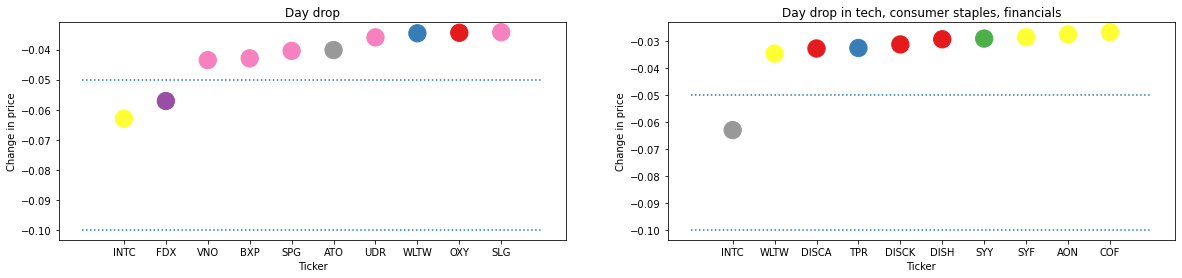

In [8]:
day_drop = df_pricechanges.sort_values(by=['pct_change1D'])[["Symbol", "Security", "GICS_Sector", 
                                                        "GICS_Sub_Industry", "latestPrice", 
                                                             "pct_change1D", "pct_change1W","pct_changeFrom1YHigh"]]

if len(sys.argv) == 1 or "ipykernel_launcher" in sys.argv[0]:
    make_charts(day_drop, "pct_change1D", "Day")
    day_drop.head(20).style.format({'latestPrice': "{:.2f}", 'pct_change1D': "{:.2%}", 
                                'pct_change1W': "{:.2%}", 'pct_changeFrom1YHigh': "{:.2%}"}, na_rep= "N/A")

# Largest drops from one week

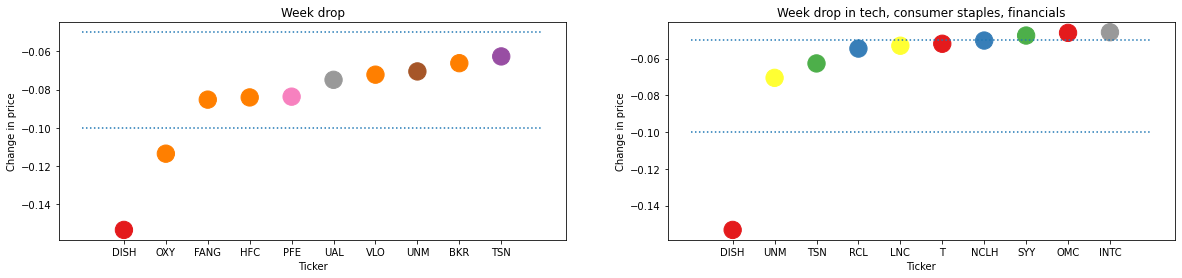

In [9]:
week_drop = df_pricechanges.sort_values(by=['pct_change1W'])[["Symbol", "Security", "GICS_Sector", 
                                                        "GICS_Sub_Industry", "latestPrice","lastweekPrice",
                                                              "pct_change1W","pct_changeFrom1YHigh"]]

if len(sys.argv) == 1 or "ipykernel_launcher" in sys.argv[0]:
    make_charts(week_drop, "pct_change1W", "Week")
    week_drop.head(20).style.format({'latestPrice': "{:.2f}", 'lastweekPrice': "{:.2f}", 'pct_change1W': "{:.2%}", 
                                 'pct_changeFrom1YHigh': "{:.2%}"}, na_rep= "N/A")

# Largest drops from one-year high

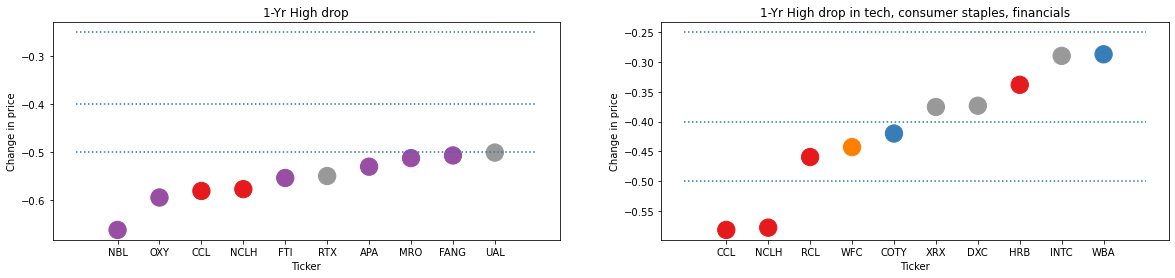

In [10]:
yearhigh_drop = df_pricechanges.sort_values(by=['pct_changeFrom1YHigh'])[["Symbol", "Security", "GICS_Sector", 
                                            "GICS_Sub_Industry", "latestPrice", "week52High","pct_changeFrom1YHigh"]]

if len(sys.argv) == 1 or "ipykernel_launcher" in sys.argv[0]:
    make_charts(yearhigh_drop, "pct_changeFrom1YHigh", "1-Yr High")
    yearhigh_drop.head(40).style.format({'latestPrice': "{:.2f}", 'week52High': "{:.2f}", 
                                     'pct_changeFrom1YHigh': "{:.2%}"}, na_rep= "N/A")

### Code for sending the results

In [11]:
def format_sectors(data):
    name_bold = "font-weight: bold" if data["GICS_Sector"] in sectors_of_interest else "font-weight: normal"
    cols = ["" if index != "Security" else name_bold for index, value in data.items()]
    return cols

def format_pricedrops(data, pricedropfield, thresholds, colors):
    background_color = "none"
    for i, threshold in enumerate(thresholds):
        if data[pricedropfield] < threshold:
            background_color = colors[i]
    background_color = "background-color: " + background_color if background_color != "none" else None
    cols = ["" if index != "Security" else background_color for index, value in data.items()]
    return cols
    
def getDataForEmail():
    day_drop_styled = day_drop[day_drop["GICS_Sector"]!= "Energy"][day_drop["pct_change1D"] < -0.05]
    if (len(day_drop_styled.index) < 5):
        day_drop_styled = day_drop[day_drop["GICS_Sector"]!= "Energy"].head(5)
    day_drop_styled = day_drop_styled.rename({"pct_change1D": "1DayChange", "pct_change1W": "1WeekChange", 
                                              "pct_changeFrom1YHigh": "1YrHighChange"}, axis=1)
    day_drop_styled = day_drop_styled.style.format({'latestPrice': "{:.2f}", '1DayChange': "{:.2%}",
                                                    '1WeekChange': "{:.2%}", '1YrHighChange': "{:.2%}"}, na_rep= "N/A") \
        .apply(format_sectors, axis=1) \
        .apply(format_pricedrops, pricedropfield="1DayChange", 
               thresholds=[-0.05, -0.1], colors=["lightsteelblue", "steelblue"], axis=1) \
        .hide_columns(['GICS_Sector']) \
        .hide_index() \
        .set_table_attributes('cellspacing="0"') \
        .set_table_styles(
           [{
               'selector': 'table',
               'props': [
                   ('border-collapse', 'collapse')]
           }, {
               'selector': 'th',
               'props': [
                   ('border-collapse', 'collapse'),
                   ('background-color', 'gray'),
                   ('color', 'white'),
                   ('border-color', 'black'),
                   ('border-style ', 'solid'),
                   ('border-width','1px')]
           },
            {
               'selector': 'td',
               'props': [
                   ('border-collapse', 'collapse'),
                   ('border-color', 'black'),
                   ('border-style ', 'solid'),
                   ('border-width','1px')]
           }
           ])
    
    week_drop_styled = week_drop[week_drop["GICS_Sector"]!= "Energy"][week_drop["pct_change1W"] < -0.05]
    if (len(week_drop_styled.index) < 5):
        week_drop_styled = week_drop[week_drop["GICS_Sector"]!= "Energy"].head(5)
    week_drop_styled = week_drop_styled.rename({"pct_change1W": "1WeekChange", 
                                              "pct_changeFrom1YHigh": "1YrHighChange"}, axis=1)
    week_drop_styled = week_drop_styled.style.format({'latestPrice': "{:.2f}", 'lastweekPrice': "{:.2f}", 
                                                      '1WeekChange': "{:.2%}", '1YrHighChange': "{:.2%}"}, na_rep= "N/A") \
        .apply(format_sectors, axis=1) \
        .apply(format_pricedrops, pricedropfield="1WeekChange", 
               thresholds=[-0.05, -0.1], colors=["lightsteelblue", "steelblue"], axis=1) \
        .hide_columns(['GICS_Sector']) \
        .hide_index() \
        .set_table_attributes('cellspacing="0"') \
        .set_table_styles(
           [{
               'selector': 'table',
               'props': [
                   ('border-collapse', 'collapse')]
           }, {
               'selector': 'th',
               'props': [
                   ('border-collapse', 'collapse'),
                   ('background-color', 'gray'),
                   ('color', 'white'),
                   ('border-color', 'black'),
                   ('border-style ', 'solid'),
                   ('border-width','1px')]
           },
            {
               'selector': 'td',
               'props': [
                   ('border-collapse', 'collapse'),
                   ('border-color', 'black'),
                   ('border-style ', 'solid'),
                   ('border-width','1px')]
           }
           ])
    
    yearhigh_drop_styled = yearhigh_drop[yearhigh_drop["GICS_Sector"]!= "Energy"][yearhigh_drop["pct_changeFrom1YHigh"] < -0.25]
    if (len(yearhigh_drop_styled.index) < 5):
        yearhigh_drop_styled = yearhigh_drop[yearhigh_drop["GICS_Sector"]!= "Energy"].head(5)
    yearhigh_drop_styled = yearhigh_drop_styled.rename({"pct_changeFrom1YHigh": "1YrHighChange"}, axis=1)
    yearhigh_drop_styled = yearhigh_drop_styled.style.format({'latestPrice': "{:.2f}", 'week52High': "{:.2f}", 
                                                              '1YrHighChange': "{:.2%}"}, na_rep= "N/A") \
        .apply(format_pricedrops, pricedropfield="1YrHighChange", 
               thresholds=[-0.25, -0.4], colors=["lightsteelblue", "steelblue"], axis=1) \
        .apply(format_sectors, axis=1) \
        .hide_columns(['GICS_Sector']) \
        .hide_index() \
        .set_table_attributes('cellspacing="0"') \
        .set_table_styles(
           [{
               'selector': 'table',
               'props': [
                   ('border-collapse', 'collapse')]
           }, {
               'selector': 'th',
               'props': [
                   ('border-collapse', 'collapse'),
                   ('background-color', 'gray'),
                   ('color', 'white'),
                   ('border-color', 'black'),
                   ('border-style ', 'solid'),
                   ('border-width','1px')]
           },
            {
               'selector': 'td',
               'props': [
                   ('border-collapse', 'collapse'),
                   ('border-color', 'black'),
                   ('border-style ', 'solid'),
                   ('border-width','1px')]
           }
           ])
    
    return day_drop_styled, week_drop_styled, yearhigh_drop_styled

In [12]:
sendEmail = "n"
if len(sys.argv) == 1 or "ipykernel_launcher" in sys.argv[0]:
    sendEmail =  input("Send email? (y/n)")

if (len(sys.argv) > 1 and not "ipykernel_launcher" in sys.argv[0]) or sendEmail == "y":
    ### CONFIG
    import config
    from premailer import transform

    ### DATA
    dayDrops, weekDrops, YearHighDrops = getDataForEmail()
    
    ### EMAIL
    import smtplib, ssl
    from email.mime.text import MIMEText
    from email.mime.multipart import MIMEMultipart

    message = MIMEMultipart("alternative")
    message["Subject"] = "Price Drop Stock Report - " + datetime.today().strftime("%m/%d/%Y") 
    message["From"] = config.email["senderEmail"]
    message["To"] = ';'.join(config.email["receiverEmails"])

    # Create the plain-text and HTML version of your message
    text = """\
    Hello,
    Here are today's stocks with the largest 1 day, 1 week and 1 year price drops:
    """
    html = """\
    <html>
      <body>
        <p>Hello,<br>
           Here are today's stocks with the largest 1 day, 1 week and 1 year price drops:<br>
        </p>
        """ \
        + "<div><h4>Price drops for the day</h4>" + transform(dayDrops.render()) + "</div>" \
        + "<div><h4>Price drops over 7 days</h4>" + transform(weekDrops.render()) + "</div>" \
        + "<div><h4>Price drops from year high</h4>" + transform(YearHighDrops.render()) + "</div>" \
    """\
      </body>
    </html>
    """

    # Turn these into plain/html MIMEText objects
    part1 = MIMEText(text, "plain")
    part2 = MIMEText(html, "html")

    # Add HTML/plain-text parts to MIMEMultipart message
    # The email client will try to render the last part first
    message.attach(part1)
    message.attach(part2)

    # Create secure connection with server and send email
    context = ssl.create_default_context()
    with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=context) as server:
        for receiver in config.email["receiverEmails"]:
            server.login(config.email["senderEmail"], config.email["senderPassword"])
            server.sendmail(
                config.email["senderEmail"], receiver, message.as_string()
            )

Send email? (y/n)y


C:\Users\meisi\Anaconda3\envs\stockprices\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\meisi\Anaconda3\envs\stockprices\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meisi\Anaconda3\envs\stockprices\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
